## =========================================================
## 1. Problem Statement
## =========================================================
## Objective:
## Explore the relationship between Bitcoin market sentiment (Fear & Greed Index)
## and trader performance using Hyperliquid historical trader data.
## The goal is to uncover patterns and insights that can inform smarter trading strategies.

## Datasets Used:
## 1. Bitcoin Market Sentiment Dataset (Fear/Greed Index)
## Columns: Date, Classification (Fear/Greed)
## 2. Historical Trader Data from Hyperliquid
## Columns include: account, symbol, execution price, size, side, time,
## start position, event, closedPnL, leverage, etc.


## =========================================================
## 2. Import Required Libraries
## =========================================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Display settings
pd.set_option('display.max_columns', None)


### =========================================================
### 3. Load the Datasets
### =========================================================

In [4]:
# NOTE:
# Download the datasets from the provided Google Drive links
# and place them in the same directory as this notebook.


# Fear & Greed Index dataset
fear_greed = pd.read_csv("fear_greed_index.csv")


# Hyperliquid trader historical data
trades = pd.read_csv("historical_data.csv")


print("Fear & Greed Data Shape:", fear_greed.shape)
print("Trader Data Shape:", trades.shape)

Fear & Greed Data Shape: (2644, 4)
Trader Data Shape: (211224, 16)


### =========================================================
### 4. Data Understanding & Cleaning
### =========================================================

In [5]:
# ---- Fear & Greed Dataset ----
fear_greed.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [9]:
# Convert Date column to datetime
fear_greed['date'] = pd.to_datetime(fear_greed['date'])

In [10]:
fear_greed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       2644 non-null   int64         
 1   value           2644 non-null   int64         
 2   classification  2644 non-null   object        
 3   date            2644 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 82.8+ KB


In [11]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [14]:
# Clean column names (remove spaces)
trades.columns = trades.columns.str.strip().str.lower().str.replace(' ', '_')


In [15]:
print(trades.columns)

Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp'],
      dtype='object')


In [17]:
trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'], errors='coerce')

# Extract Date
trades['Date'] = trades['timestamp_ist'].dt.date
trades['Date'] = pd.to_datetime(trades['Date'])

In [18]:
# Take only Bitcoin
btc_trades = trades[trades['coin'].str.contains('BTC', case=False, na=False)]

In [19]:
# Remove Missing values 
btc_trades = btc_trades.dropna(subset=['closed_pnl', 'Date'])

In [20]:
# Sanity check
print("BTC Trades Shape:", btc_trades.shape)
btc_trades[['execution_price', 'size_usd', 'closed_pnl']].describe()

BTC Trades Shape: (9660, 17)


,execution_price,size_usd,closed_pnl
count,9660.000000,9.660000e+03,9660.000000
mean,83021.998654,1.969496e+04,31.770566
std,15163.120373,6.772294e+04,569.648098
min,41866.000000,4.300000e-01,-29370.119800
25%,79103.000000,5.059100e+02,0.000000
50%,83281.000000,2.221635e+03,0.000000
75%,96094.250000,1.813466e+04,1.089900
max,103265.000000,3.509753e+06,19530.522500


In [21]:
# MERGE with Fear & Greed Index
merged_df = pd.merge(
    btc_trades,
    fear_greed[['date', 'classification', 'value']],
    left_on='Date',
    right_on='date',
    how='inner'
)

print("Merged Data Shape:", merged_df.shape)
merged_df.head()


Merged Data Shape: (3162, 20)


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,Date,date,classification,value
0,0x8381e6d82f1affd39a336e143e081ef7620a3b7f,BTC,99156.0,0.00859,851.75,BUY,2025-04-02 19:30:00,0.00000,Open Long,0.0,0xf93ca8d08c3f41ce255d041d20152e02035d0086ce11...,69450859817,True,0.298112,1.080000e+15,1.740000e+12,2025-04-02,2025-04-02,Fear,44
1,0x8381e6d82f1affd39a336e143e081ef7620a3b7f,BTC,99156.0,0.23100,22905.04,BUY,2025-04-02 19:30:00,0.00859,Open Long,0.0,0xf93ca8d08c3f41ce255d041d20152e02035d0086ce11...,69450859817,True,8.016762,5.320000e+14,1.740000e+12,2025-04-02,2025-04-02,Fear,44
2,0x8381e6d82f1affd39a336e143e081ef7620a3b7f,BTC,99156.0,0.88000,87257.28,BUY,2025-04-02 19:30:00,0.23959,Open Long,0.0,0xf93ca8d08c3f41ce255d041d20152e02035d0086ce11...,69450859817,True,30.540048,1.570000e+13,1.740000e+12,2025-04-02,2025-04-02,Fear,44
3,0x8381e6d82f1affd39a336e143e081ef7620a3b7f,BTC,99156.0,0.77000,76350.12,BUY,2025-04-02 19:30:00,1.11959,Open Long,0.0,0xf93ca8d08c3f41ce255d041d20152e02035d0086ce11...,69450859817,True,26.722542,8.340000e+14,1.740000e+12,2025-04-02,2025-04-02,Fear,44
4,0x8381e6d82f1affd39a336e143e081ef7620a3b7f,BTC,99156.0,0.21200,21021.07,BUY,2025-04-02 19:30:00,1.88959,Open Long,0.0,0xf93ca8d08c3f41ce255d041d20152e02035d0086ce11...,69450859817,True,7.357375,7.970000e+14,1.740000e+12,2025-04-02,2025-04-02,Fear,44


In [22]:
# Trader Performance vs Market Sentiment
sentiment_pnl = (
    merged_df
    .groupby('classification')['closed_pnl']
    .mean()
    .sort_values()
)

sentiment_pnl

classification
Greed            17.311808
Neutral          26.565798
Extreme Fear     39.156426
Extreme Greed    41.561424
Fear             54.157691
Name: closed_pnl, dtype: float64

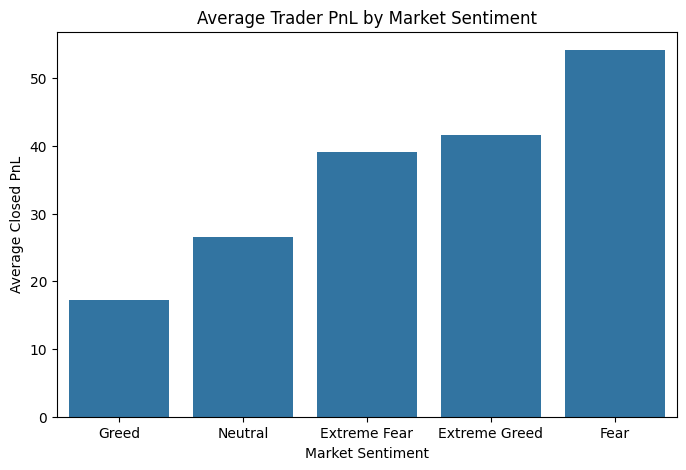

In [23]:
#Visualization
plt.figure(figsize=(8,5))
sns.barplot(
    x=sentiment_pnl.index,
    y=sentiment_pnl.values
)
plt.title("Average Trader PnL by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Closed PnL")
plt.show()


In [24]:
#Trade Direction Vs Sentiment
direction_sentiment = (
    merged_df
    .groupby(['classification', 'side'])
    .size()
    .unstack()
)

direction_sentiment

side,BUY,SELL
classification,,
Extreme Fear,105,40
Extreme Greed,133,186
Fear,633,355
Greed,772,711
Neutral,119,108


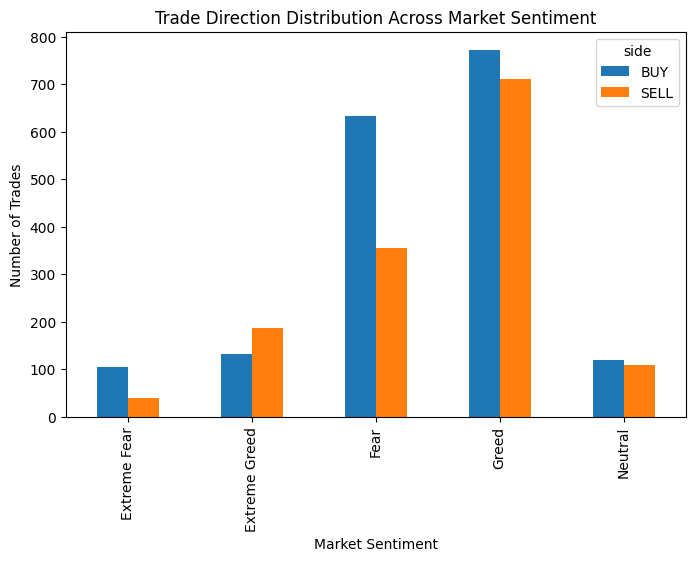

In [25]:
direction_sentiment.plot(kind='bar', figsize=(8,5))
plt.title("Trade Direction Distribution Across Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Number of Trades")
plt.show()

In [26]:
#Trade Size Vs Sentiments
size_sentiment = (
    merged_df
    .groupby('classification')['size_usd']
    .mean()
)

size_sentiment

classification
Extreme Fear     14694.040759
Extreme Greed    14481.774890
Fear             15993.807480
Greed             9958.834815
Neutral          20292.118238
Name: size_usd, dtype: float64

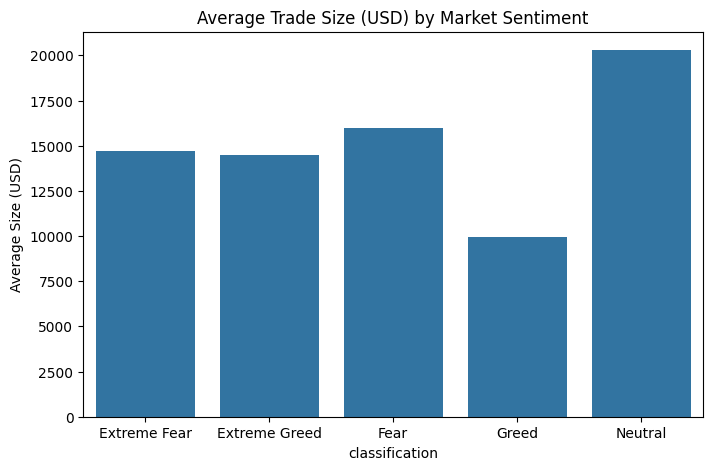

In [27]:
plt.figure(figsize=(8,5))
sns.barplot(
    x=size_sentiment.index,
    y=size_sentiment.values
)
plt.title("Average Trade Size (USD) by Market Sentiment")
plt.ylabel("Average Size (USD)")
plt.show()

In [28]:
#Correlation Analysis
corr = merged_df[['value', 'closed_pnl', 'size_usd']].corr()
corr

,value,closed_pnl,size_usd
value,1.000000,-0.044721,-0.055749
closed_pnl,-0.044721,1.000000,0.259092
size_usd,-0.055749,0.259092,1.000000


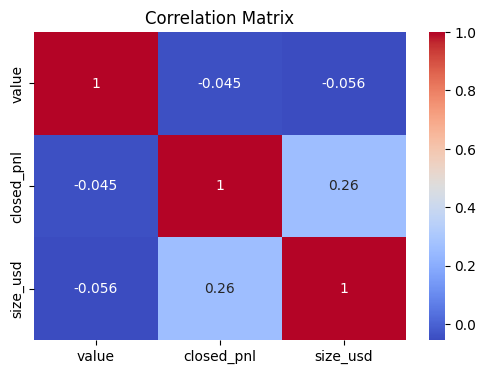

In [29]:
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()
